# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to have a full control on what is created, and to have a proper "ground truth" to compare with. 

To do so, we could use MEArec (https://github.com/alejoe91/MEArec) a python package that can help you to generate such artificial datasets.
Here we will use a build-in simplify version to generate ground grouth recording.

Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. 
The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated



In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%matplotlib inline

In [22]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si

from probeinterface import generate_multi_columns_probe

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Step 1 : generate a probe and a fake recording

(-70.0, 120.0)

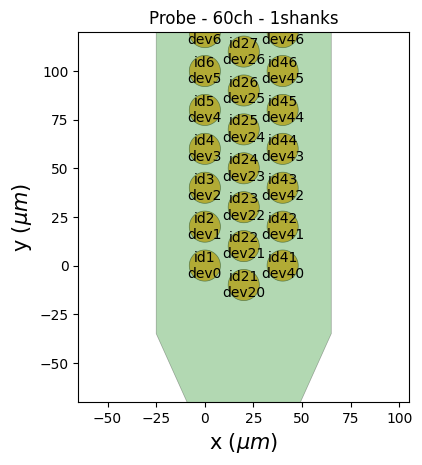

In [24]:
# generate a fake probe
fig, ax = plt.subplots()
probe = generate_multi_columns_probe(
    num_columns=3,
    num_contact_per_column=20,
    xpitch=20,
    ypitch=20,
    y_shift_per_column=[0, -10, 0],
    contact_shapes="circle",
    contact_shape_params={"radius": 8},
    
)
probe.set_contact_ids([f'{i+1}' for i in range(probe.get_contact_count())])
probe.set_device_channel_indices(np.arange(probe.get_contact_count()))


from probeinterface.plotting import plot_probe
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)
ax.set_ylim(-70, 120)

In [28]:
seed = 2205

recording, sorting_gt = si.generate_ground_truth_recording(
   durations=[180.0],
   sampling_frequency=30000.,
    probe=probe,
    num_units=40,
    generate_sorting_kwargs={
      'firing_rates': 4,
      'refractory_period_ms': 1.5
    },
    generate_unit_locations_kwargs={
      'margin_um': 10.0,
      'minimum_z': 10.0,'maximum_z': 50.0
    },
    noise_kwargs={'noise_level': 5.
    },
    generate_templates_kwargs={
        'unit_params_range': {
            'alpha' : (6000., 9000.),
            'decay_power': (1.2, 1.8),
        },
    },
    seed=seed,
    )
recording

InjectTemplatesRecording: 60 channels - 30.0kHz - 1 segments - 5,400,000 samples 
                          180.00s (3.00 minutes) - float32 dtype - 1.21 GiB

In [29]:
# basedir = Path('.')
# basedir = Path('/data_local/DataSpikeSorting/SI_tutorial_marseille_2023')
basedir = Path('/home/samuel/DataSpikeSorting/SI_tutorial_marseille_2023')
# filename = basedir / 'Simulated_Neuronexus-32.h5'


# recording, sorting_gt = si.read_mearec(filename)

In [30]:
recording

InjectTemplatesRecording: 60 channels - 30.0kHz - 1 segments - 5,400,000 samples 
                          180.00s (3.00 minutes) - float32 dtype - 1.21 GiB

In [31]:
sorting_gt

NumpySorting: 40 units - 1 segments - 30.0kHz

## Step 2 : open and plot the signals and the spikes from our ground truth

In [10]:
waveforms_gt = si.extract_waveforms(recording, sorting_gt,
                                    # folder=basedir/'waveforms_simulated',
                                    folder=None, 
                                    mode="memory",
                                     ms_before=1.5, ms_after=1.5, sparse=True,
                                     n_jobs=-1)


extract waveforms shared_memory multi buffer:   0%|          | 0/180 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/180 [00:00<?, ?it/s]

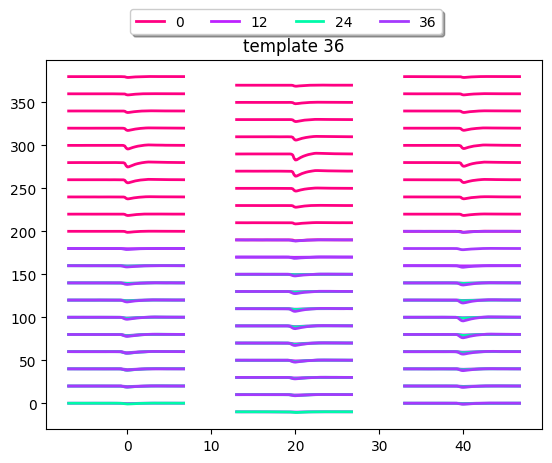

In [11]:
si.plot_unit_templates(waveforms_gt, backend='matplotlib', unit_ids=sorting_gt.unit_ids[::12], same_axis=True)

In [12]:
%matplotlib widget
si.plot_timeseries(recording, time_range=(5,5.1), backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

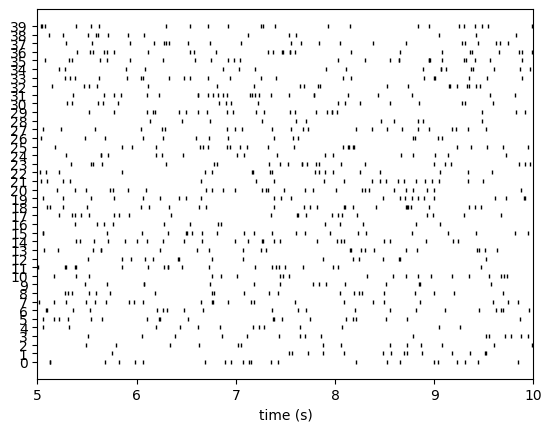

In [13]:
# We can also look at spikes
%matplotlib inline
si.plot_rasters(sorting_gt, time_range=(5,10))

In [14]:
metrics = si.compute_quality_metrics(waveforms_gt, metric_names=['firing_rate', 'snr'])
metrics.head(8)

,firing_rate,snr
0,4.0,19.320583
1,4.0,21.815025
2,4.0,32.989059
3,4.0,21.779690
4,4.0,11.524025
5,4.0,30.835917
6,4.0,0.888106
7,4.0,27.142298


Text(0.5, 0, 'snr')

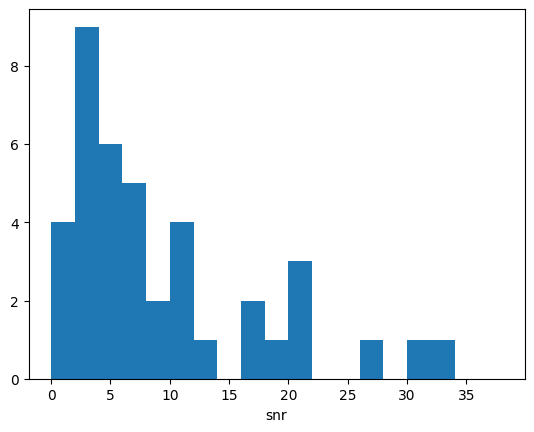

In [15]:
fig, ax = plt.subplots()
_ = ax.hist(metrics['snr'], bins=np.arange(0, 40, 2))
ax.set_xlabel('snr')

In [16]:
# only 20 units are easy too catch!!
num_big_units = np.sum(metrics['snr'] > 5)
num_big_units

24

## Step 3 : run several sorters on GT recording

In [17]:
# si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')

With spikeinterface, launching a spike sorting algorithm is easy. You simply need to do use the run_sorter command. Assuming we want to save every sorting into a specific folder, with a name dedicated to every sorter, we can simply do

In [46]:
# sorter_names = ['kilosort2_5', 'spykingcircus2', 'tridesclous2', 'tridesclous'] #  'spykingcircus',
# sorter_names = [ 'spykingcircus2', 'tridesclous2',] 
sorter_names = ['spykingcircus2',  'tridesclous2', 'mountainsort5',] # 

In [47]:
sortings = {}

for sorter_name in sorter_names:
    output_folder = basedir / f'fakedata_sorter_output_{sorter_name}'
    if output_folder.exists():
        sortings[sorter_name] = si.sorter_dict[sorter_name].get_result_from_folder(output_folder)
    else:
        sortings[sorter_name] = si.run_sorter(sorter_name, recording, output_folder, verbose=True)
# Note that the sorter list can includes 'kilosort', 'herdingspikes', ... See spikeinterface wrapper for more info

Warning! The recording is already filtered, but mountainsort5 filter is enabled
filtering
whitening
Number of channels: 60
Number of timepoints: 5400000
Sampling frequency: 30000.0 Hz
Channel 0: [0. 0.]
Channel 1: [ 0. 20.]
Channel 2: [ 0. 40.]
Channel 3: [ 0. 60.]
Channel 4: [ 0. 80.]
Channel 5: [  0. 100.]
Channel 6: [  0. 120.]
Channel 7: [  0. 140.]
Channel 8: [  0. 160.]
Channel 9: [  0. 180.]
Channel 10: [  0. 200.]
Channel 11: [  0. 220.]
Channel 12: [  0. 240.]
Channel 13: [  0. 260.]
Channel 14: [  0. 280.]
Channel 15: [  0. 300.]
Channel 16: [  0. 320.]
Channel 17: [  0. 340.]
Channel 18: [  0. 360.]
Channel 19: [  0. 380.]
Channel 20: [ 20. -10.]
Channel 21: [20. 10.]
Channel 22: [20. 30.]
Channel 23: [20. 50.]
Channel 24: [20. 70.]
Channel 25: [20. 90.]
Channel 26: [ 20. 110.]
Channel 27: [ 20. 130.]
Channel 28: [ 20. 150.]
Channel 29: [ 20. 170.]
Channel 30: [ 20. 190.]
Channel 31: [ 20. 210.]
Channel 32: [ 20. 230.]
Channel 33: [ 20. 250.]
Channel 34: [ 20. 270.]
Channel 

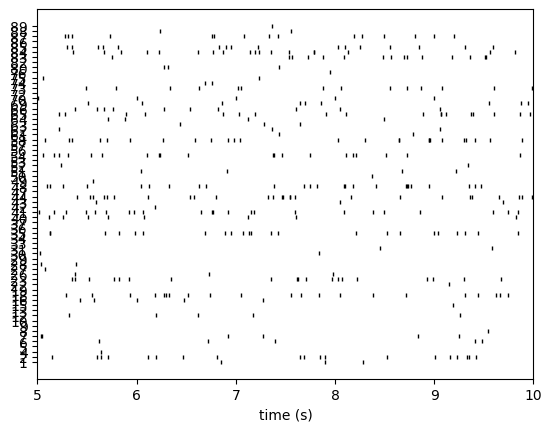

In [48]:
# We can also look at spikes
si.plot_rasters(sortings['tridesclous2'], time_range=(5,10))

You just noticed how easy it is to run several sorters on a given recording. But what about comparisons? Now we would like to be able to quantify how good these sorters are, with respect to the ground truth units that have been created. 

## Step 4 : run comparison and plot agreement matrix for one sorter

Once we have a given spike sorting, we can always compare it to its ground-truth, via the comparison object offered by spikeinterface

In [49]:
comparisons = {}
for sorter_name in sorter_names:
    comparisons[sorter_name] = si.compare_sorter_to_ground_truth(sorting_gt, sortings[sorter_name])

In [50]:
# comp_sc2 = comparisons['spykingcircus2']
# comp_sc = comparisons['spykingcircus']
# comp_tdc = comparisons['tridesclous']
comp_tdc2 = comparisons['tridesclous2']

Such a comparison object can immediatly tell us how many units are found, what are the errors rates, and much more

In [51]:
comp_tdc2.agreement_scores # TO view the quality score between units

,1,2,4,5,6,7,8,9,10,12,...,76,80,82,83,84,85,86,87,88,89
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001004,...,0.000000,0.003736,0.000000,0.002088,0.000786,0.002791,0.000000,0.000861,0.000000,0.000000
1,0.000000,0.003101,0.000000,0.000000,0.002384,0.001076,0.000000,0.000000,0.001279,0.002010,...,0.000000,0.000000,0.000000,1.000000,0.001574,0.002092,0.001280,0.000861,0.002430,0.000000
2,0.000000,0.001548,0.001319,0.000000,0.000000,0.001076,0.000000,0.000000,0.000000,0.002010,...,0.000000,0.000000,0.000000,0.002786,0.000000,0.001394,0.000000,0.001723,0.000000,0.000000
3,0.000000,0.000773,0.000000,0.000000,0.001190,0.000000,0.000000,0.000000,0.000000,0.001004,...,0.000000,0.000000,0.000000,0.001391,0.002362,0.002791,0.000000,0.000861,0.001214,0.000000
4,0.000000,0.000773,0.000000,0.000000,0.000000,0.001076,0.000000,0.000000,0.000000,0.384722,...,0.000000,0.000000,0.000000,0.001391,0.001574,0.000696,0.000000,0.001723,0.000000,0.000000
5,0.000000,0.002324,0.000000,0.000000,0.000000,0.001076,0.000000,0.000000,0.000000,0.001004,...,0.001166,0.000000,0.000000,0.000695,0.002362,0.002791,0.001280,0.000000,0.002430,0.000000
6,0.000000,0.000773,0.000000,0.000000,0.001190,0.001076,0.000000,0.000000,0.000000,0.000000,...,0.001166,0.000000,0.000000,0.001391,0.003152,0.001394,0.000000,0.000861,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.001190,0.001076,0.000000,0.000000,0.000000,0.002010,...,0.000000,0.000000,0.000000,0.000695,0.000000,0.000696,0.000000,0.002586,0.002430,0.001170
8,0.001295,0.000000,0.000000,0.000000,0.000000,0.001076,0.000000,0.000000,0.000000,0.002010,...,0.002334,0.000000,0.000000,0.001391,0.000000,0.000696,0.001280,0.613037,0.000000,0.001170
9,0.001295,0.000000,0.001319,0.000000,0.001190,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001166,0.000000,0.000000,0.000695,0.001574,0.002092,0.000000,0.001723,0.002430,0.000000


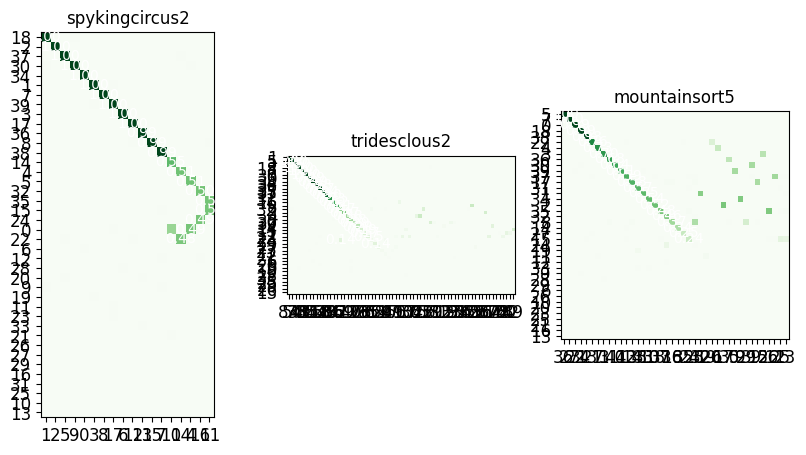

In [52]:
%matplotlib inline
n = len(sorter_names)
fig, axs = plt.subplots(ncols=n, figsize=(10, 5))

for i, sorter_name in enumerate(sorter_names):
    si.plot_agreement_matrix(comparisons[sorter_name], ax=axs[i])
    ax = axs[i]
    axs[i].set_title(sorter_name)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
plt.show()

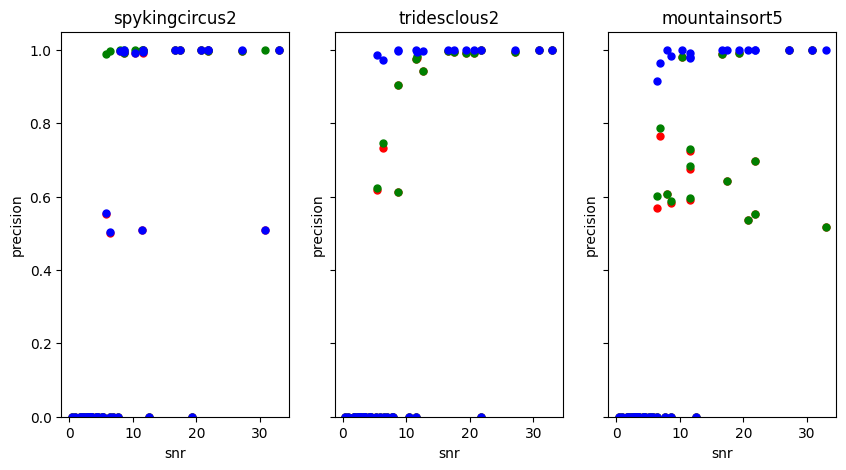

In [53]:
fig, axes = plt.subplots(1, len(sorter_names), figsize=(10, 5), sharey=True)
metrics = si.compute_quality_metrics(waveforms_gt, metric_names=['snr'], load_if_exists=True)

# for i, key in enumerate(study.cases):
for i, sorter_name in enumerate(sorter_names):
    ax = axes[i]
    ax.set_title(sorter_name)
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='accuracy', metric_name='snr', ax=ax, color='r')
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='recall', metric_name='snr', ax=ax, color='g')
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='precision', metric_name='snr', ax=ax, color='b')        


## Step 5 : agreement between sorters

What if we have several spike sorting algorithms, and want to quickly compare each of them? The comparison could be performed on a single recording, and/or or various recordings at once, to get a more global comparison. 

Let's first start with the simple case of a single comparison, on a single recording. As said, you can easily, with spikeinterface, compare the results accross sorters. To do so, the simplest option is to launch the sorters individually, and compare the results via a so-called aggrement study

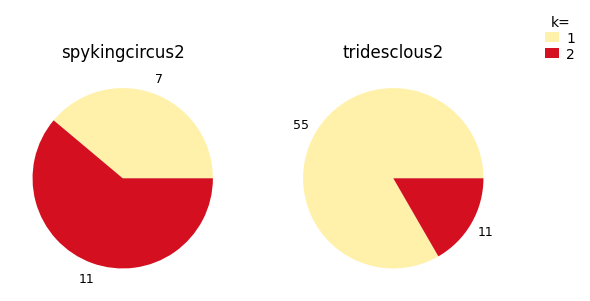

In [42]:
comp = si.compare_multiple_sorters(list(sortings.values()), sorter_names)
si.plot_multicomp_agreement_by_sorter(comp)

## Step 6 : Challenging the collisions

In [43]:
collisions_comparisons = {}
for i, sorter_name in enumerate(sorter_names):
    collisions_comparisons[sorter_name] = si.CollisionGTComparison(sorting_gt, sortings[sorter_name])


In [44]:
templates = waveforms_gt.get_all_templates()

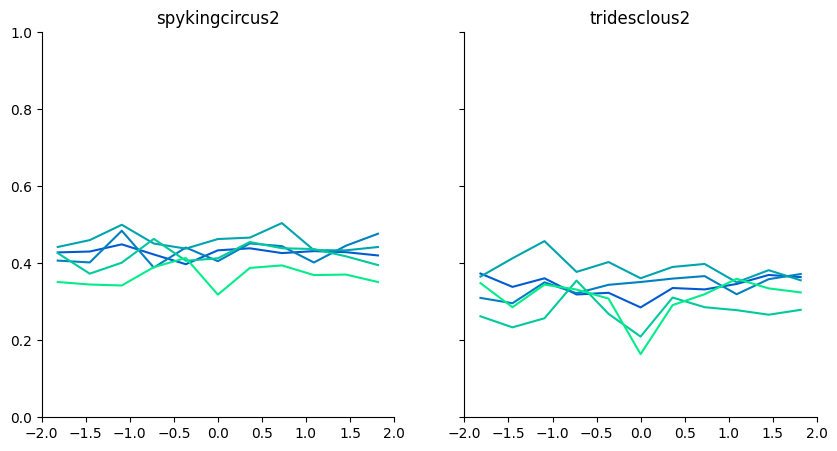

In [45]:
n = len(sorter_names)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 5), sharey=True)

for i, sorter_name in enumerate(sorter_names):
    si.plot_comparison_collision_by_similarity(collisions_comparisons[sorter_name], templates, mode='lines', 
                                               good_only=False, ax=axes[i])
    axes[i].set_title(sorter_name)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)
